In [1]:
#This notebook is going to use the accelwattch_results to look at the Accelwattch power_ubench
#While the accelwattch_power_ubench.csv was generated from the util/accelwattch/gen_sim_power_csv.py program directly


In [2]:
import csv
import os 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


In [3]:
benchmarks = []
basedir = os.getcwd()
reportsdir = os.path.join(basedir,"accelwattch_results")
os.listdir(reportsdir)



['accelwattch_ubench_datatype_volta_sass_sim.csv',
 'accelwattch_TeslaV100_Incomplete_BadLCDInsts_volta_sass_hw.csv',
 'accelwattch_power_ubench.csv',
 'accelwattch_volta_hw_sass_GPU_Microbench.csv',
 'accelwattch_QV100_volta_sass_hw.csv',
 'accelwattch_TeslaV100_BadLDC-Accelwattch_SASS_SIM.csv',
 'accelwattch_TeslaV100_tuner_only_volta_sass_hw.csv',
 'accelwattch_power_ubench_datatype_sass_sim.csv',
 'hw_power_results.csv']

In [4]:
def aggregate_predicted_values(predicted_df):
    predicted_df['ALUP']=predicted_df['INTP']+predicted_df['INT_MULP']
    predicted_df['FPU_DPUP']=predicted_df['FPUP']+predicted_df['FP_MULP']+predicted_df['DPUP']+predicted_df['DP_MULP']
    predicted_df['SFUP']=predicted_df['FP_SQRTP']+predicted_df['FP_LGP']+predicted_df['FP_SINP']+predicted_df['FP_EXP']
    predicted_df['L1D_SHRDP']=predicted_df['DCP']+predicted_df['SHRDP']
    predicted_df['ICACHE_CCACHEP']=predicted_df['ICP']+predicted_df['CCP']
    predicted_df['L2_NOCP']=predicted_df['L2CP']
    predicted_df['DRAM_MCP']=predicted_df['DRAMP']
    predicted_df['OTHERP']=predicted_df['IBP']+predicted_df['TEXP']+predicted_df['SCHEDP']+predicted_df['PIPEP']
    return predicted_df
def process_df_dict(df_dict):
    if 'predicted' in df_dict:
        df_dict['predicted']['Unnamed: 0'] = df_dict['predicted']['Unnamed: 0'].str.replace('+','',regex=False)
        df_dict['predicted'] = df_dict['predicted'].rename(columns={"Unnamed: 0": "KERNEL_NAME"})
        df_dict['predicted'] = df_dict['predicted'].sort_values('KERNEL_NAME').reset_index(drop=True)
        df_dict['predicted']['KERNEL_NAME'] = df_dict['predicted']['KERNEL_NAME'].str.replace('-','_',regex=False)
        df_dict['predicted']['KERNEL_NAME'] = df_dict['predicted']['KERNEL_NAME'].str.replace('rodinia_3.1_','',regex=False)
        df_dict['predicted']['KERNEL_NAME'] = df_dict['predicted']['KERNEL_NAME'].str.replace('i_q','iq',regex=False)
        df_dict['predicted']['KERNEL_NAME'] = df_dict['predicted']['KERNEL_NAME'].str.replace('perf_test_','',regex=False)
        df_dict['predicted'] = aggregate_predicted_values(df_dict['predicted'])
        # Replace with '_P'
        # df_dict['predicted']['KERNEL_NAME'] = df_dict['predicted']['KERNEL_NAME'].str.replace('P$', '',regex=True)  
    if 'measured' in df_dict:
        df_dict['measured'] = df_dict['measured'].sort_values('Unnamed: 0')
        m_df = df_dict['measured']
        m_df = m_df[~ m_df['Unnamed: 0'].str.contains("pathfinder")].reset_index(drop=True)
        m_df = m_df.rename(columns={"Unnamed: 0": "Kernel Names"})
    #Either add measured data or just return predictions
    if 'predicted' in df_dict and 'measured' in df_dict:
        combined_df = pd.merge(df_dict['predicted'], m_df, left_on='KERNEL_NAME', right_on='Kernel Names')
        return combined_df
    elif 'predicted' in df_dict:
        return df_dict['predicted']
def get_data(sim_target,reportsdir=reportsdir):
    df_dict = {}
    for file in os.listdir(reportsdir):
        df = pd.read_csv(os.path.join(reportsdir,file))
        df.columns = df.columns.str.replace(',','')
        if 'hw_power' in file and any(target in sim_target for target in ["QV100", "Tesla"]):
            df_dict["measured"]=df
        elif sim_target in file:
            df_dict['predicted']=df
    return process_df_dict(df_dict)


In [5]:
custom_colors = ["#D9D9D9","#A5A5A5","#F7C8A8","#8CB9E1","#868686","#A97655","#D68B58","#BAD5ED","#637492","#F2A46F","#646A71","#C5CEDA","#7C8796"]
custom_colors.reverse()

# Define the columns for stacking
stack_columns = ['CONSTP', 'STATICP', 'IDLE_COREP','RFP', 'ALUP', 'FPU_DPUP', 'SFUP', 'TENSORP', 'L1D_SHRDP', 'ICACHE_CCACHEP', 'L2_NOCP', 'DRAM_MCP', 'OTHERP']

In [6]:
def create_component_breakdown_graph(predicted_df, title="", value_format="raw",
                                     stack_columns=stack_columns,colors=custom_colors,
                                     height=6,width=None,legend=True, ylimit=None):
    '''
    Description: Create a stacked bar graph with particular setups similar to graphs from AccelWattch paper
    
    '''
    # Set the x-axis labels
    x_labels = predicted_df['KERNEL_NAME']

    # Set the values for each stacked column
    stack_values = predicted_df[stack_columns].values.T
    x_axis = np.arange(len(stack_values[0]))
    if len(x_axis) == 0:
        return None
    # print(stack_values)
    num_bars = len(x_axis)
    bar_width = 0.7
    bar_offset = 0
    annotation_threshold = predicted_df[stack_columns].sum(axis=1).mean()/12
    print(f"My threshold is {annotation_threshold}")
    # Plot the stacked bar graph
    plt.figure(figsize=(num_bars * bar_width * 1.5 if width is None else width, height))
    bottom = None
    for i, column in enumerate(stack_columns):
        plt.bar(x_axis - bar_offset,
                stack_values[i], width=bar_width,
                bottom=bottom,
                label=column,
               # color=colors[i % len(colors)]
               )
        if value_format == "percentage":
            for j, val in enumerate(stack_values[i]):
                if val >= annotation_threshold:  # Adjust the threshold as needed
                    plt.text((x_axis[j] - bar_offset), bottom[j] if bottom is not None else 0,
                             f"{(val/predicted_df['kernel_avg_power'].iloc[j]) * 100:.1f}%", ha='center', va='bottom', color="black",
                             bbox={'boxstyle': 'round,pad=0.1','facecolor': 'lightgray', 'edgecolor': 'gray', 'alpha': 0.7})
        elif value_format == "raw":
            for j, val in enumerate(stack_values[i]):
                if val >= annotation_threshold:  # Adjust the threshold as needed
                    plt.text((x_axis[j] - bar_offset), bottom[j] if bottom is not None else 0,
                             f"{val:.2f}", ha='center', va='bottom', color="black",
                             bbox={'boxstyle': 'round,pad=0.1','facecolor': 'lightgray', 'edgecolor': 'gray', 'alpha': 0.7})
        if bottom is None:
            bottom = np.array(stack_values[i])
        else:
            bottom += np.array(stack_values[i])

    # Rotate the x-labels by 45 degrees and align them to the right
    plt.xticks(x_axis, x_labels, rotation=-22.5, ha='left')

    # Set y-axis limit if specified
    if ylimit is not None:
        plt.ylim(0, ylimit)

    # Add labels and title
    plt.xlabel('Kernel Name')
    plt.ylabel('Power (W)')
    plt.title(title)
    if legend:
        # Add legend with reversed order
        handles, labels = plt.gca().get_legend_handles_labels()
        handles = handles[::-1]
        labels = labels[::-1]
        labels=[label[:-1]+ '_P' if label[-1]=='P' else label for label in labels]
        plt.legend(handles, labels, loc='upper right', bbox_to_anchor=(1+(2.5/num_bars), 1), markerscale=10)

    return plt


In [7]:
power_ubench_df = get_data("power_ubench.csv")
power_ubench_df = power_ubench_df[power_ubench_df.KERNEL_NAME != 'BE_HP_FP_ADD_k1']
power_ubench_df

,KERNEL_NAME,IBP,ICP,DCP,TCP,CCP,SHRDP,RFP,INTP,FPUP,...,STATICP,kernel_avg_power,ALUP,FPU_DPUP,SFUP,L1D_SHRDP,ICACHE_CCACHEP,L2_NOCP,DRAM_MCP,OTHERP
0,BE_DP_FP_ADD_k1,0.448837,0.0,1.484030,0.0,0.0,0.000000,16.926000,0.644614,0.000000,...,26.052400,121.8400,0.995406,31.918800,0.000000,1.484030,0.0,1.402421,0.981230,2.945067
1,BE_DP_FP_DIV_k1,1.581660,0.0,0.405146,0.0,0.0,0.000000,46.277900,14.702200,5.145300,...,31.087500,169.9010,20.266050,22.948448,1.995630,0.405146,0.0,0.383103,0.667957,9.884080
2,BE_DP_FP_MAD_k1,0.511708,0.0,0.908060,0.0,0.0,0.000000,26.090200,0.242805,0.000000,...,30.623000,112.9720,0.457595,13.472400,0.000000,0.908060,0.0,0.853743,0.813862,3.372578
3,BE_DP_FP_MUL_k1,0.446203,0.0,1.484780,0.0,0.0,0.000000,16.824100,0.495841,0.000000,...,25.953700,100.7340,0.846633,11.094100,0.000000,1.484780,0.0,1.403267,0.981576,2.927673
4,BE_L1D_HIT_k1,0.004732,0.0,0.033621,0.0,0.0,0.000000,0.180207,0.030047,0.000000,...,0.190176,55.7521,0.047155,0.000000,0.000000,0.033621,0.0,0.037651,0.565615,0.030468
5,BE_L1D_HIT_k2,0.179754,0.0,92.977600,0.0,0.0,0.000000,3.007820,0.487475,0.000000,...,23.278200,177.2310,0.817489,0.000000,0.000000,92.977600,0.0,0.887662,15.396830,1.175208
6,BE_L2D_HIT_k1,0.004732,0.0,0.033621,0.0,0.0,0.000000,0.180207,0.030047,0.000000,...,0.190176,55.7521,0.047155,0.000000,0.000000,0.033621,0.0,0.037651,0.565615,0.030468
7,BE_L2D_HIT_k2,0.040410,0.0,0.112456,0.0,0.0,0.000000,3.791470,0.109587,0.000000,...,31.618400,82.9233,0.183776,0.000000,0.000000,0.112456,0.0,11.179800,1.461218,0.264194
8,BE_MEM_DRAM_Acss_k1,0.058603,0.0,6.667160,0.0,0.0,0.000000,2.548560,0.609914,0.000000,...,31.946100,114.9680,0.897305,0.000000,0.000000,6.667160,0.0,5.231370,33.963150,0.370215
9,BE_MEM_SHRD_Acss_k1,0.412413,0.0,0.655540,0.0,0.0,6.790910,10.746700,0.628127,0.000000,...,21.093300,85.4069,1.053365,0.000000,0.000000,7.446450,0.0,0.620930,0.767550,2.697923


<h1>Looking Through My Microbench </h1>

In [8]:
dp_tensor_df = power_ubench_df[power_ubench_df.KERNEL_NAME.str.contains('DP') | power_ubench_df.KERNEL_NAME.str.contains('TENSOR_k2')]
dp_tensor_df

,KERNEL_NAME,IBP,ICP,DCP,TCP,CCP,SHRDP,RFP,INTP,FPUP,...,STATICP,kernel_avg_power,ALUP,FPU_DPUP,SFUP,L1D_SHRDP,ICACHE_CCACHEP,L2_NOCP,DRAM_MCP,OTHERP
0,BE_DP_FP_ADD_k1,0.448837,0.0,1.484030,0.0,0.0,0.0,16.9260,0.644614,0.000000,...,26.0524,121.840,0.995406,31.918800,0.00000,1.484030,0.0,1.402421,0.981230,2.945067
1,BE_DP_FP_DIV_k1,1.581660,0.0,0.405146,0.0,0.0,0.0,46.2779,14.702200,5.145300,...,31.0875,169.901,20.266050,22.948448,1.99563,0.405146,0.0,0.383103,0.667957,9.884080
2,BE_DP_FP_MAD_k1,0.511708,0.0,0.908060,0.0,0.0,0.0,26.0902,0.242805,0.000000,...,30.6230,112.972,0.457595,13.472400,0.00000,0.908060,0.0,0.853743,0.813862,3.372578
3,BE_DP_FP_MUL_k1,0.446203,0.0,1.484780,0.0,0.0,0.0,16.8241,0.495841,0.000000,...,25.9537,100.734,0.846633,11.094100,0.00000,1.484780,0.0,1.403267,0.981576,2.927673
24,TENSOR_k2,0.184384,0.0,7.504530,0.0,0.0,0.0,8.2792,1.165430,0.002758,...,28.8265,108.187,1.702054,0.002758,0.00000,7.504530,0.0,3.168310,2.496407,1.177969


My threshold is 10.22722521


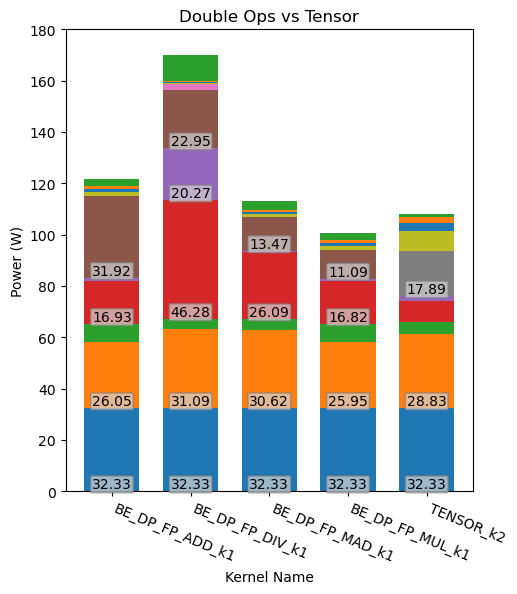

In [9]:
create_component_breakdown_graph(dp_tensor_df,"Double Ops vs Tensor", legend=False,ylimit=180).show()

My threshold is 9.625099398804348


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

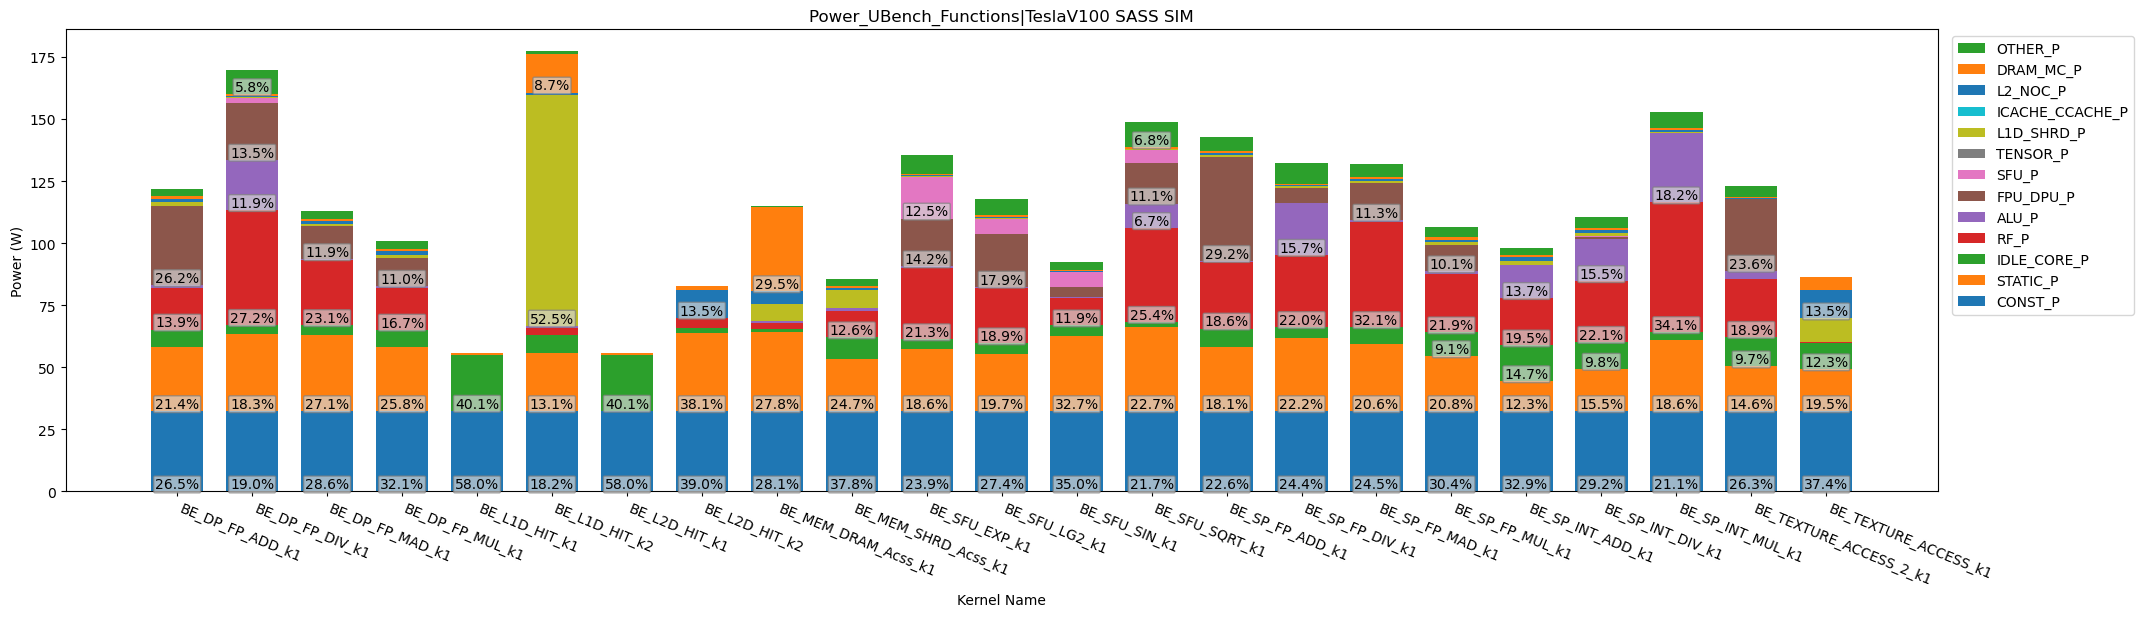

In [10]:
create_component_breakdown_graph(power_ubench_df[power_ubench_df.KERNEL_NAME.str.contains("BE")],"Power_UBench_Functions|TeslaV100 SASS SIM",value_format="percentage")

My threshold is 10.417416300555557


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

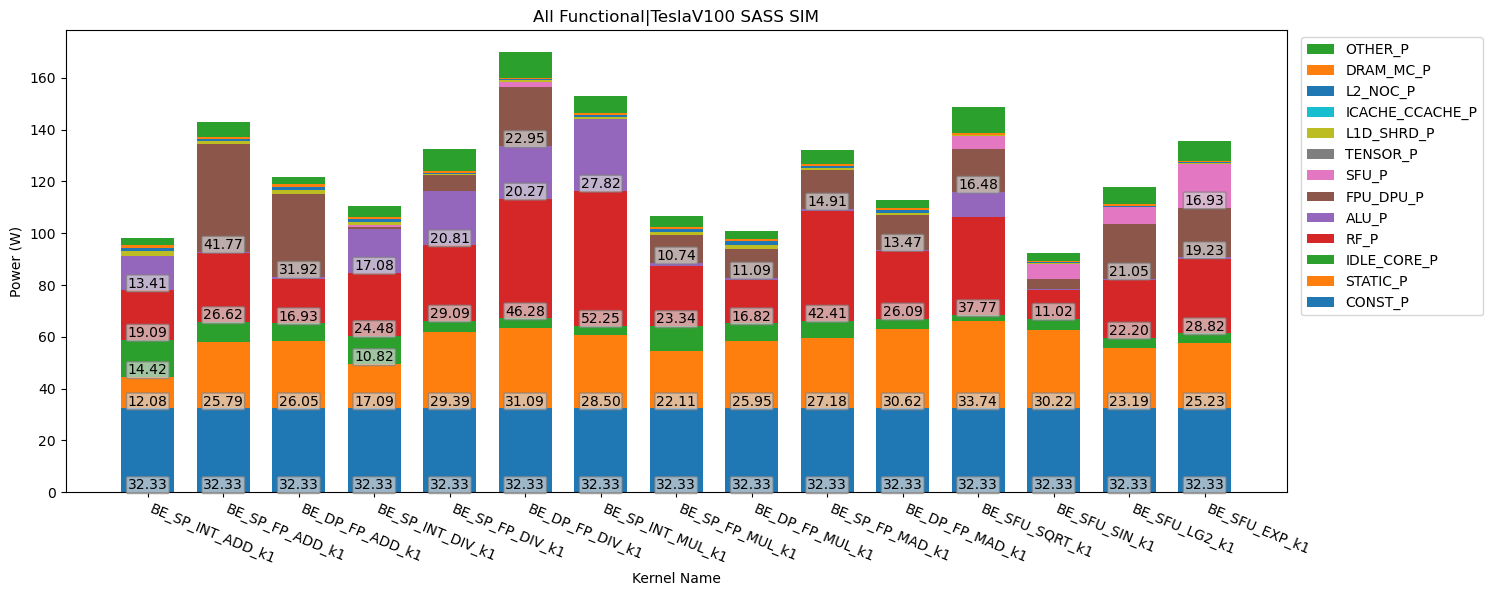

In [11]:
functions_df = pd.concat([power_ubench_df[power_ubench_df.KERNEL_NAME.str.contains("ADD")].sort_index(ascending=False),
                          power_ubench_df[power_ubench_df.KERNEL_NAME.str.contains("DIV")].sort_index(ascending=False),
                          power_ubench_df[power_ubench_df.KERNEL_NAME.str.contains("MUL")].sort_index(ascending=False),
                          power_ubench_df[power_ubench_df.KERNEL_NAME.str.contains("MAD")].sort_index(ascending=False),
                          power_ubench_df[power_ubench_df.KERNEL_NAME.str.contains("SFU")].sort_index(ascending=False),])

create_component_breakdown_graph(functions_df,"All Functional|TeslaV100 SASS SIM")

My threshold is 10.420067038888888


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

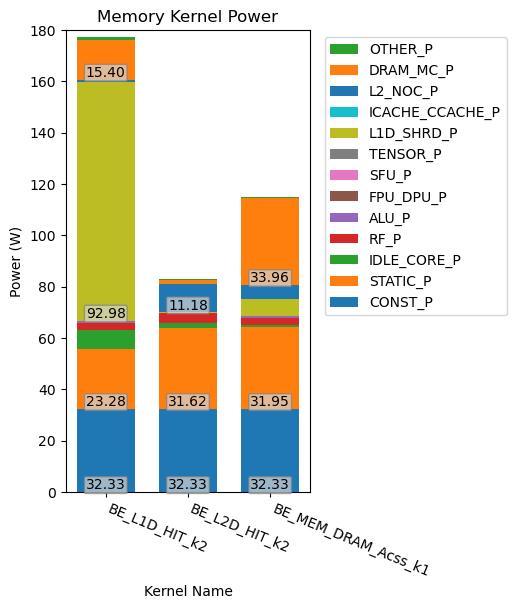

In [12]:
scaling = 0.8
create_component_breakdown_graph(power_ubench_df[#power_ubench_df.KERNEL_NAME.str.contains("ACC")|
                                                 power_ubench_df.KERNEL_NAME.str.contains("MEM_DRAM")|
                                                 (power_ubench_df.KERNEL_NAME.str.contains("BE_L")&
                                                    ~power_ubench_df.KERNEL_NAME.str.contains("HIT_k1"))],
                                 "Memory Kernel Power",#"Power_UBench_Memory|TeslaV100 SASS SIM",
                                    # legend=False,
                                 height=6,ylimit=180)

My threshold is 11.435859157916669


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

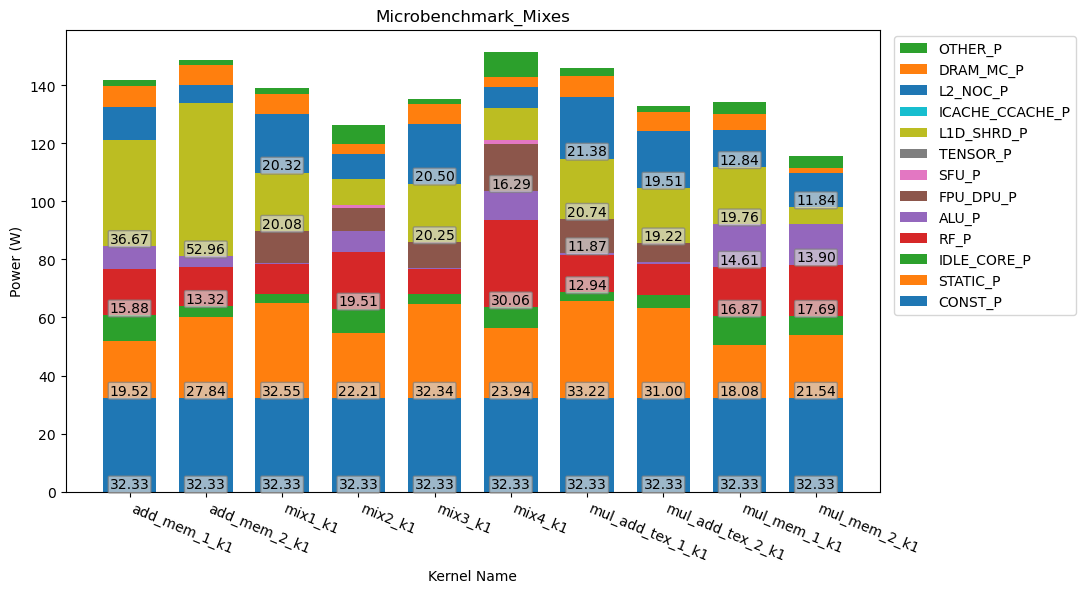

In [13]:
create_component_breakdown_graph(power_ubench_df[~power_ubench_df.KERNEL_NAME.str.contains("BE")
                                                 &~power_ubench_df.KERNEL_NAME.str.contains("TENSOR")],
                                 "Microbenchmark_Mixes")#"Power_UBench_Mix/Tensor|TeslaV100 SASS SIM")

In [14]:
def hex_to_rgb(hex_code):
    hex_code = hex_code.lstrip('#')
    r = int(hex_code[0:2], 16)
    g = int(hex_code[2:4], 16)
    b = int(hex_code[4:6], 16)
    return r, g, b

def find_suitable_text_color(palette_colors_rgb):
    def contrast(rgb1, rgb2):
        # Calculate the contrast ratio between two RGB colors
        lum1 = 0.2126 * rgb1[0] + 0.7152 * rgb1[1] + 0.0722 * rgb1[2]
        lum2 = 0.2126 * rgb2[0] + 0.7152 * rgb2[1] + 0.0722 * rgb2[2]
        if lum1 > lum2:
            return (lum1 + 0.05) / (lum2 + 0.05)
        else:
            return (lum2 + 0.05) / (lum1 + 0.05)

    def find_suitable_contrast_color(base_rgb, palette_colors_rgb):
        max_contrast = 0
        best_color = None
        for color_rgb in palette_colors_rgb:
            current_contrast = contrast(base_rgb, color_rgb)
            if current_contrast > max_contrast:
                max_contrast = current_contrast
                best_color = color_rgb
        return best_color

    # Create a dictionary to store the suitable text color for each color in the palette
    text_colors_dict = {}

    # Find the suitable text color for each color in the palette
    for base_color in palette_colors_rgb:
        text_color = find_suitable_contrast_color(base_color, palette_colors_rgb)
        text_colors_dict[base_color] = text_color

    return text_colors_dict


# Convert hex colors to RGB format
palette_colors_rgb = [hex_to_rgb(color_hex) for color_hex in custom_colors]

# Find the suitable text color for each color in the palette
text_colors_dict = find_suitable_text_color(palette_colors_rgb)

print("Text Colors for Palette:")
for base_color, text_color in text_colors_dict.items():
    print(f"Base Color (RGB): {base_color}, Text Color (RGB): {text_color}")


Text Colors for Palette:
Base Color (RGB): (124, 135, 150), Text Color (RGB): (217, 217, 217)
Base Color (RGB): (197, 206, 218), Text Color (RGB): (100, 106, 113)
Base Color (RGB): (100, 106, 113), Text Color (RGB): (217, 217, 217)
Base Color (RGB): (242, 164, 111), Text Color (RGB): (100, 106, 113)
Base Color (RGB): (99, 116, 146), Text Color (RGB): (217, 217, 217)
Base Color (RGB): (186, 213, 237), Text Color (RGB): (100, 106, 113)
Base Color (RGB): (214, 139, 88), Text Color (RGB): (100, 106, 113)
Base Color (RGB): (169, 118, 85), Text Color (RGB): (217, 217, 217)
Base Color (RGB): (134, 134, 134), Text Color (RGB): (217, 217, 217)
Base Color (RGB): (140, 185, 225), Text Color (RGB): (100, 106, 113)
Base Color (RGB): (247, 200, 168), Text Color (RGB): (100, 106, 113)
Base Color (RGB): (165, 165, 165), Text Color (RGB): (100, 106, 113)
Base Color (RGB): (217, 217, 217), Text Color (RGB): (100, 106, 113)


<h1> Data Type exploration </h1>

In [15]:
ubench_datatype_df = get_data("accelwattch_ubench_datatype_volta_sass_sim")#accelwattch_power_ubench_datatype_sass_sim")# 
ubench_datatype_df = ubench_datatype_df[(ubench_datatype_df.KERNEL_NAME != 'BE_HP_FP_ADD_k1') & (ubench_datatype_df.KERNEL_NAME != 'BE_HP_FP_MUL_k1')]

My threshold is 10.2944686875


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

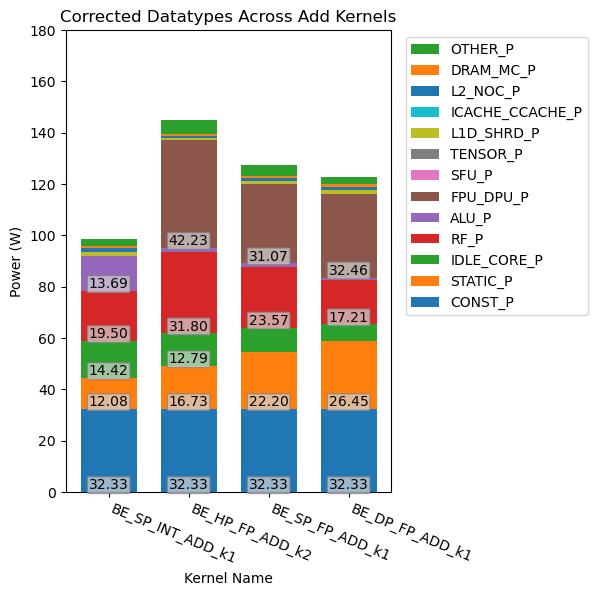

In [16]:
add_ubench_datatype_df = ubench_datatype_df[ubench_datatype_df.KERNEL_NAME.str.contains("ADD")]
datatype_df = pd.concat([add_ubench_datatype_df[add_ubench_datatype_df.KERNEL_NAME.str.contains("INT")
                                         #& ~ubench_datatype_df.KERNEL_NAME.str.contains("SP_FP")
                                        ].sort_index(ascending=False),
                          add_ubench_datatype_df[add_ubench_datatype_df.KERNEL_NAME.str.contains("HP")].sort_index(ascending=False),
                          add_ubench_datatype_df[add_ubench_datatype_df.KERNEL_NAME.str.contains("SP_FP")].sort_index(ascending=False),
                          add_ubench_datatype_df[add_ubench_datatype_df.KERNEL_NAME.str.contains("DP")].sort_index(ascending=False),
                        ])
create_component_breakdown_graph(datatype_df,
                                 "Corrected Datatypes Across Add Kernels",value_format="raw",
                                 
                                 height=6,ylimit=180)
#WHEN MEASURED
# BE_SP_INT_ADD_2000000000    146.984032
# BE_HP_FP_ADD_2000000000     158.188341
# BE_SP_FP_ADD_2000000000     141.554018
# BE_DP_FP_ADD_2000000000     139.558501

# INT     98.807
# HP     145.082
# SP     127.304
# DP     122.942

My threshold is 2.5712656666666667


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

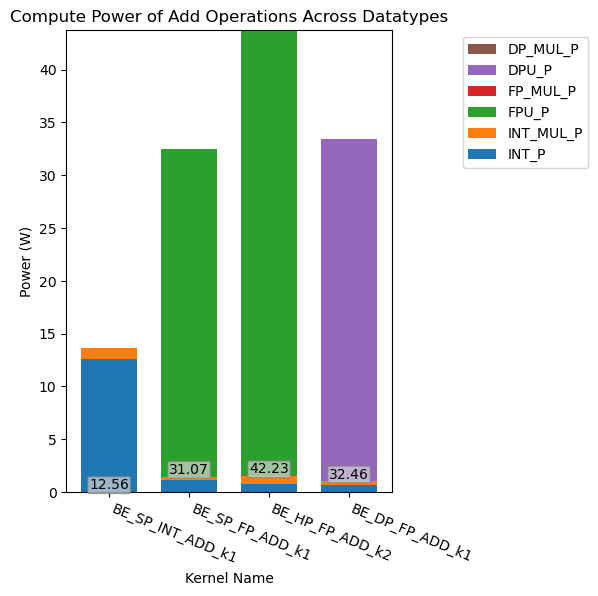

In [17]:
datatype_df = pd.concat([ubench_datatype_df[ubench_datatype_df.KERNEL_NAME.str.contains("ADD")].sort_index(ascending=False),
                          # ubench_datatype_df[ubench_datatype_df.KERNEL_NAME.str.contains("DIV")].sort_index(ascending=False),
                          # ubench_datatype_df[ubench_datatype_df.KERNEL_NAME.str.contains("MUL")].sort_index(ascending=False),
                        ])
create_component_breakdown_graph(datatype_df,
                                 "Compute Power of Add Operations Across Datatypes",
                                 stack_columns=['INTP','INT_MULP','FPUP','FP_MULP','DPUP','DP_MULP'],
                                 # value_format="raw", 
                                 colors=custom_colors[4:])

My threshold is 8.712636972222223


,KERNEL_NAME,kernel_avg_power
5,BE_HP_FP_MUL_k2,106.458
7,BE_SP_FP_MUL_k1,106.463
1,BE_DP_FP_MUL_k1,100.734


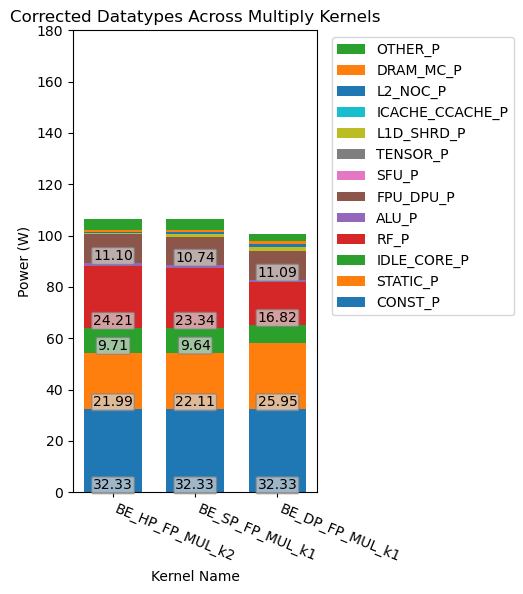

In [31]:
mul_ubench_datatype_df = ubench_datatype_df[ubench_datatype_df.KERNEL_NAME.str.contains("MUL")]
datatype_df = pd.concat([mul_ubench_datatype_df[mul_ubench_datatype_df.KERNEL_NAME.str.contains("INT")
                                         #& ~ubench_datatype_df.KERNEL_NAME.str.contains("SP_FP")
                                        ].sort_index(ascending=False),
                          mul_ubench_datatype_df[mul_ubench_datatype_df.KERNEL_NAME.str.contains("HP")].sort_index(ascending=False),
                          mul_ubench_datatype_df[mul_ubench_datatype_df.KERNEL_NAME.str.contains("SP_FP")].sort_index(ascending=False),
                          mul_ubench_datatype_df[mul_ubench_datatype_df.KERNEL_NAME.str.contains("DP")].sort_index(ascending=False),
                        ])
create_component_breakdown_graph(datatype_df,
                                 "Corrected Datatypes Across Multiply Kernels",value_format="raw",                                 
                                 height=6,ylimit=180)
datatype_df[['KERNEL_NAME','kernel_avg_power']]

In [19]:
binaries = ubench_datatype_df.KERNEL_NAME.str.replace("_k[0-9]$","",regex=True).to_list()
for binary in sorted(list(set(binaries))):
    iters = 100 #100 is original #1000000 was for exec time significance
    if any(item in binary for item in ["DIV","_mem","mix",'TENSOR']):
        iters /= 10
    if "DRAM" in binary:
        iters /= 100
    print(binary,int(iters))

BE_DP_FP_ADD 100
BE_DP_FP_MUL 100
BE_HP_FP_ADD 100
BE_HP_FP_MUL 100
BE_SP_FP_ADD 100
BE_SP_FP_MUL 100
BE_SP_INT_ADD 100
